In [1]:
import sys
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from fast_tsne import fast_tsne
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from Modules import rnaseqTools
from Modules import file_navigation
from Modules import read_data

In [2]:
def get_color_dataframe():
    fname = 'References/marker_ref.txt'
    params = {'sep':'\t', 'header':0, 'index_col':0}
    df = pd.read_csv(fname, **params)
    
    return df

def read_ephys_data():
    df_ephys = read_data.read_ephys_data(age_cutoff=20)
    
    fname = 'Datasets/Lab_Pvalb-labels.tsv'
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    df_labels = pd.read_csv(fname, **kwargs)
    #df_labels = df_labels.loc[df_labels.Age>20]
    #df_ephys = df_ephys.loc[df_ephys.index.isin(df_labels.index)]
    df_labels = df_labels.loc[df_ephys.index]
    
    return df_labels, df_ephys

def get_data():
    df_labels, df_ephys = read_ephys_data()
    df_marker = get_color_dataframe()
    datalist = StandardScaler().fit_transform(df_ephys.values)
    #df_ephys = df_ephys.sub(df_ephys.min(axis=0))
    #df_ephys = df_ephys.div(df_ephys.mean(axis=0))
    
    df_ephys = pd.DataFrame(datalist, index=df_ephys.index, columns=df_ephys.columns)
    
    return df_labels, df_ephys, df_marker

def do_preliminary_reduction(df, normalize=False, feature_selection=True, filename='Lin_Kobak'):
    df = np.log2(1+df)
    if normalize:
        datalist = StandardScaler().fit_transform(df.values)
        df = pd.DataFrame(datalist, index=df.index, columns=df.columns)
    if feature_selection:
        df = do_feature_selection(df, filename=filename)
    
    pca = PCA(n_components=50)
    datalist = pca.fit_transform(df.values)
    df_pca = pd.DataFrame(datalist, index=df.index)
    
    return df_pca

def perform_embeddings(df, perplexity=10, normalize=False, trim=True, feature_selection=True, filename='Lin_Kobak'):
    if trim:
        df_pca = do_preliminary_reduction(df,
                                          normalize=normalize,
                                          feature_selection=feature_selection,
                                          filename=filename
                                         )
    else:
        df_pca = df
        if normalize:
            datalist = StandardScaler().fit_transform(df_pca.values)
            df_pca = pd.DataFrame(datalist, index=df_pca.index, columns=df_pca.columns)
    
    columns = ['PCA_X', 'PCA_Y',
               'tsne_X', 'tsne_Y',
               'fittsne_X', 'fittsne_Y',
               'umap_X', 'umap_Y']
    df_embedding = pd.DataFrame(np.NaN, index=df_pca.index, columns=columns)
    
    pca = PCA(n_components=2)
    columns = ['PCA_X', 'PCA_Y']
    df_embedding[columns] = pca.fit_transform(df_pca)
    
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    columns = ['tsne_X', 'tsne_Y']
    df_embedding[columns] = tsne.fit_transform(df_pca)
    
    reducer = umap.UMAP(n_components=2, n_neighbors=perplexity, min_dist=.01, random_state=42, metric='euclidean')
    columns = ['umap_X', 'umap_Y']
    df_embedding[columns] = reducer.fit_transform(df_pca)
    
    datalist = fast_tsne(df_pca.values, perplexity = perplexity,
                            learning_rate = df_pca.shape[0]/12, knn_algo='vp-tree', seed=42)
    columns = ['fittsne_X', 'fittsne_Y']
    df_embedding[columns] = datalist    
    
    return df_embedding

def generate_embeddings_data(perplexity_trans=10, perplexity_ephys=10, perplexity_cam=10):
    df_lin, df_lab, df_ephys, df_nbtsne, df_nbtsne_old = get_data()
    df_cam = get_cam_data(df_lin)
    
    # do embedding on tpm data
    df_embedding = perform_embeddings(df_lin, perplexity=perplexity_trans, filename='Lin_Kobak')
    df_embedding['nbtsne_X'] = df_nbtsne_old.Plot_X
    df_embedding['nbtsne_Y'] = df_nbtsne_old.Plot_Y
    df_embedding.to_csv('Mapping/Embeddings/Lab_Pvalb-tpm.tsv', sep='\t')
    
    df_embedding = perform_embeddings(df_lab, perplexity=perplexity_trans, filename='Lab_Kobak')
    df_embedding.to_csv('Mapping/Embeddings/Lab_Data-tpm.tsv', sep='\t')
    
    df_embedding = perform_embeddings(df_cam, perplexity=perplexity_cam, feature_selection=False)
    df_embedding.to_csv('Mapping/Embeddings/Lab_Pvalb-cam.tsv', sep='\t')
    
    # do embedding on ephys data
    df_embedding = perform_embeddings(df_ephys, perplexity=perplexity_ephys, normalize=True, trim=False)
    df_embedding.to_csv('Mapping/Embeddings/Lab_Pvalb-ephys.tsv', sep='\t')
    
    return

In [3]:
def make_plot(df_ephys, colors, min_dist, n_neighbors, ax):
    reducer = umap.UMAP(n_components=2,
                        n_neighbors=n_neighbors,
                        min_dist=min_dist,
                        random_state=42,
                        metric='euclidean'
                       )
    #reducer = TSNE(n_components=2, perplexity=n_neighbors)
    plotlist = reducer.fit_transform(df_ephys.values)
    
    ax.scatter(plotlist[:,0], plotlist[:,1], color=colors)
    ax.set_xticks([]), ax.set_yticks([])
    ax.set_title('UMAP Perp: %d, Dist: %.2e' % (n_neighbors, min_dist))
    
    return

def make_plots(df_ephys, colors, fig):
    dists = [.0001, .0001, .0001, .001, .001, .001, .01, .01, .01, .1, .1, .1]
    n_neighbors = [3,6,10] * 4
    
    for num, (dist, neighbor) in enumerate(zip(dists, n_neighbors)):
        row_num = num // 3
        col_num = num % 3
        ax = fig.add_axes([.1 + .29*col_num, .71 - .21*row_num, .22, .17])
        make_plot(df_ephys, colors, dist, neighbor, ax)
    
    return

In [4]:
df_labels, df_ephys, df_marker = get_data()

In [5]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_ephys.values)
labels = ['Ephys%d' % label for label in kmeans.labels_ + 1]
colors = [{'Ephys1':'blue', 'Ephys2':'red'}[label] for label in labels]

/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/home/soma/anaconda3/envs/analyze/lib/p

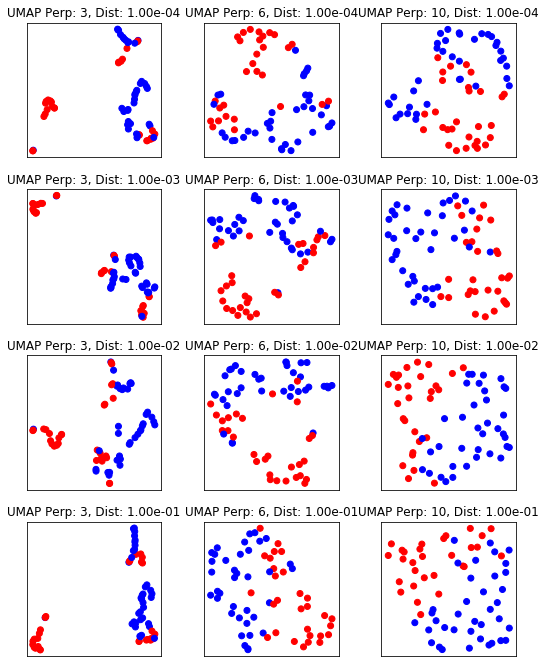

In [6]:
fig = plt.figure(figsize=(8.5,11))
make_plots(df_ephys, colors, fig)
plt.show()

In [7]:
plotlist = PCA(n_components=2).fit_transform(df_ephys)

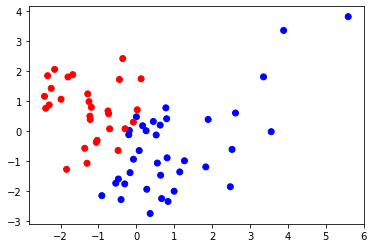

In [8]:
plt.scatter(plotlist[:,0], plotlist[:,1], color=colors)
plt.show()